In [1]:
import polars as pl
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import root_mean_squared_error
import pickle

import sys
import os

# Add the root project directory to the Python path
sys.path.append(os.path.abspath(".."))

from scripts.functions import read_dataframe, one_hot_encoding, train_model

In [2]:
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("nyc-taxi-experiment")


<Experiment: artifact_location='mlflow-artifacts:/712286886036284170', creation_time=1747060237229, experiment_id='712286886036284170', last_update_time=1747060237229, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [3]:
# ingest the data from the NYC Taxi Data website
# fetch the data from the URL instead of downloading it
green_tripdata_2021_01 = pl.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet")
green_tripdata_2021_02 = pl.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet")

In [4]:
january_data_green, df_train, categorical_features = read_dataframe(green_tripdata_2021_01)
february_data_green, df_val, categorical_features = read_dataframe(green_tripdata_2021_02)

print(f"len(df_train): {len(df_train)}, len(df_val): {len(df_val)}")

# if we look at the percentiles, we see that most of the trips are within 1 hour
# so it makes sense to focus on them
january_data_green["duration_minutes"].describe(percentiles=[0.95, 0.98, 0.99])

df_train

len(df_train): 73833, len(df_val): 61889


VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,duration_minutes,PU_DO
i64,datetime[ns],datetime[ns],str,f64,str,str,f64,f64,f64,f64,f64,f64,f64,null,f64,f64,f64,f64,f64,i64,f64,str
2,2021-01-01 00:15:56,2021-01-01 00:19:52,"""N""",1.0,"""43""","""151""",1.0,1.01,5.5,0.5,0.5,0.0,0.0,null,0.3,6.8,2.0,1.0,0.0,236,3.933333,"""43_151"""
2,2021-01-01 00:25:59,2021-01-01 00:34:44,"""N""",1.0,"""166""","""239""",1.0,2.53,10.0,0.5,0.5,2.81,0.0,null,0.3,16.86,1.0,1.0,2.75,525,8.75,"""166_239"""
2,2021-01-01 00:45:57,2021-01-01 00:51:55,"""N""",1.0,"""41""","""42""",1.0,1.12,6.0,0.5,0.5,1.0,0.0,null,0.3,8.3,1.0,1.0,0.0,358,5.966667,"""41_42"""
2,2020-12-31 23:57:51,2021-01-01 00:04:56,"""N""",1.0,"""168""","""75""",1.0,1.99,8.0,0.5,0.5,0.0,0.0,null,0.3,9.3,2.0,1.0,0.0,425,7.083333,"""168_75"""
2,2021-01-01 00:26:31,2021-01-01 00:28:50,"""N""",1.0,"""75""","""75""",6.0,0.45,3.5,0.5,0.5,0.96,0.0,null,0.3,5.76,1.0,1.0,0.0,139,2.316667,"""75_75"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2,2021-01-31 21:38:00,2021-01-31 22:16:00,null,null,"""81""","""90""",null,17.63,56.23,2.75,0.0,0.0,6.12,null,0.3,65.4,null,null,null,2280,38.0,"""81_90"""
2,2021-01-31 22:43:00,2021-01-31 23:21:00,null,null,"""35""","""213""",null,18.36,46.66,0.0,0.0,12.2,6.12,null,0.3,65.28,null,null,null,2280,38.0,"""35_213"""
2,2021-01-31 22:16:00,2021-01-31 22:27:00,null,null,"""74""","""69""",null,2.5,18.95,2.75,0.0,0.0,0.0,null,0.3,22.0,null,null,null,660,11.0,"""74_69"""


/var/folders/w8/jf3gk0856r1_y4pft74pf1v00000gn/T/ipykernel_36771/2354924393.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(january_data_green["duration_minutes"])


<Axes: xlabel='duration_minutes', ylabel='Density'>

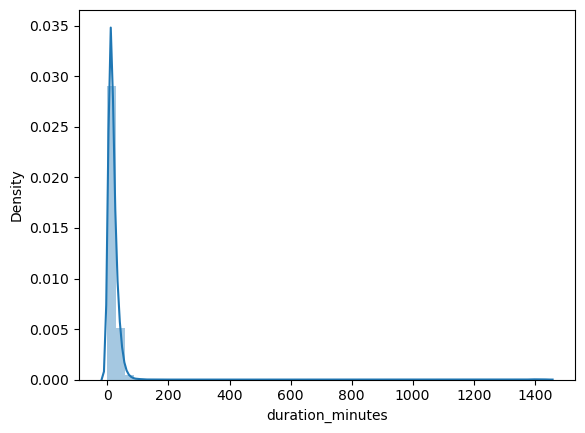

In [5]:
sns.distplot(january_data_green["duration_minutes"])


/var/folders/w8/jf3gk0856r1_y4pft74pf1v00000gn/T/ipykernel_36771/2556686641.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train["duration_minutes"])


<Axes: xlabel='duration_minutes', ylabel='Density'>

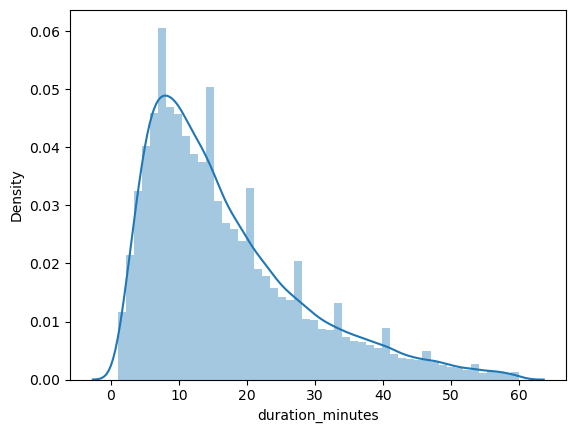

In [6]:
sns.distplot(df_train["duration_minutes"])


In [7]:
# Feature engineering
categorical_features = ["PU_DO"]
numerical_features = ["trip_distance"]
target = "duration_minutes"

X_train, X_val, dict_vectorizer = one_hot_encoding(df_train, df_val, categorical_features, numerical_features)
y_train, y_val = df_train[target], df_val[target]

lr = train_model(LinearRegression(), X_train, y_train, X_val, y_val)



In [9]:
# save this model
with open("models/lin_reg.bin", "wb") as f_out:
    pickle.dump((dict_vectorizer, lr), f_out)

# load the model
# with open("models/lin_reg.bin", "rb") as f_in:
#     dict_vectorizer, lr = pickle.load(f_in)

In [ ]:
with mlflow.start_run():
    # tag the run with the developer's name
    mlflow.set_tag("developer", "judit")
    # log the dataset being used
    mlflow.log_param("train-data-url", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-url", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet")
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    # model management: save the model to MLFlow as an artifact
    # this is the basic approach
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

🏃 View run stylish-lamb-755 at: http://127.0.0.1:5000/#/experiments/712286886036284170/runs/060de232efc14ceba4f079ee79214ad3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/712286886036284170


In [11]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
# fmin: optimize (minimize) the objective function 
# tpe: tree of parzen estimators (hyperparameter optimization algorithm)
# hp: methods to define the search space for the hyperparameters
# STATUS_OK: status of the optimization for successful runs
# Trials: object that stores the results of the optimization, keeps track of the information from the trials
from hyperopt.pyll.base import scope # scope: define the search space for the hyperparameters

# specify the data in xgb-friendly format
# DMatrix: good for handling large datasets -> faster computation, better memory management
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50,
        )
        
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        
        mlflow.log_metric("rmse", rmse)
        
    return {"loss": rmse, "status": STATUS_OK}

In [ ]:
search_space = {
    "max_depth": scope.int(hp.quniform("max_depth", 4, 100, 1)), #quniform returns a float, sample from a uniform distribution
    "learning_rate": hp.loguniform("learning_rate", -3, 0), #sample from a log-uniform distribution, range here: exp(-3) to exp(0) = 0.05 to 1
    "reg_alpha": hp.loguniform("reg_alpha", -5, -1), #regularization parameter for L1 regularization
    "reg_lambda": hp.loguniform("reg_lambda", -6, -1), #regularization parameter for L2 regularization
    "min_child_weight": hp.loguniform("min_child_weight", -1, 10),
    "objective": "reg:linear",
    "seed": 42,
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials(),
)

# once this is done, we can compare the different runs in the mlflow UI
# via parallel coordinates plot, scatter plot, box plot, and contour plot

In [14]:
# selecting the best model:
# 1. find the best runs
# 2. compare the model size / complexity and training time
# -> the best model is the one with the lowest rmse while keeping the model size / complexity and training time to a minimum

params = {
    "reg_lambda": 0.10479357768633932,
    "seed": 42,
    "max_depth": 67,
    "min_child_weight": 4.726134327631799,
    "learning_rate": 0.2254998660071301,
    "objective": "reg:linear",
    "reg_alpha": 0.012770048180595262,
}

# with certain frameworks, mlflow supports autologging
mlflow.xgboost.autolog()
booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50,
        )

2025/05/18 17:42:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'cc09f4108d974adf89d01de0b4a19f95', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
/opt/anaconda3/envs/tsa_course/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [17:42:54] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-rmse:10.43468
[1]	validation-rmse:9.18029
[2]	validation-rmse:8.31259
[3]	validation-rmse:7.72574
[4]	validation-rmse:7.33241
[5]	validation-rmse:7.07058
[6]	validation-rmse:6.89759
[7]	validation-rmse:6.77831
[8]	validation-rmse:6.69963
[9]	validation-rmse:6.64512
[10]	validation-rmse:6.60603
[11]	validation-rmse:6.57514
[12]	validation-rmse:6.55126
[13]	validation-rmse:6.53456
[14]	validation-rmse:6.52032
[15]	validation-rmse:6.51058
[16]	validation-rmse:6.50286
[17]	validation-rmse:6.49545
[18]	validation-rmse:6.48771
[19]	validation-rmse:6.48285
[20]	validation-rmse:6.47717
[21]	validation-rmse:6.47279
[22]	validation-rmse:6.46979
[23]	validation-rmse:6.46785
[24]	validation-rmse:6.46535
[25]	validation-rmse:6.46442
[26]	validation-rmse:6.46261
[27]	validation-rmse:6.46000
[28]	validation-rmse:6.45818
[29]	validation-rmse:6.45650
[30]	validation-rmse:6.45354
[31]	validation-rmse:6.45262
[32]	validation-rmse:6.45156
[33]	validation-rmse:6.45024
[34]	validation-rmse:6.

2025/05/18 17:43:12 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2025/05/18 17:43:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/tsa_course/lib/python3.12/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [17:43:12] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/05/18 17:43:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run unruly-fly-199 at: http://127.0.0.1:5000/#/experiments/712286886036284170/runs/cc09f4108d974adf89d01de0b4a19f95
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/712286886036284170


In [ ]:
# disable autologging so we don't log the model twice
mlflow.xgboost.autolog(disable=True)

with mlflow.start_run():
    mlflow.log_params(params)
    booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50,
        )
    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)
    
    # a better way to do model management
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

    # also save the dictvectorizer so we can use it for processing new data
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dict_vectorizer, f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

[0]	validation-rmse:10.43468


/opt/anaconda3/envs/tsa_course/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [18:26:55] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[1]	validation-rmse:9.18029
[2]	validation-rmse:8.31259
[3]	validation-rmse:7.72574
[4]	validation-rmse:7.33241
[5]	validation-rmse:7.07058
[6]	validation-rmse:6.89759
[7]	validation-rmse:6.77831
[8]	validation-rmse:6.69963
[9]	validation-rmse:6.64512
[10]	validation-rmse:6.60603
[11]	validation-rmse:6.57514
[12]	validation-rmse:6.55126
[13]	validation-rmse:6.53456
[14]	validation-rmse:6.52032
[15]	validation-rmse:6.51058
[16]	validation-rmse:6.50286
[17]	validation-rmse:6.49545
[18]	validation-rmse:6.48771
[19]	validation-rmse:6.48285
[20]	validation-rmse:6.47717
[21]	validation-rmse:6.47279
[22]	validation-rmse:6.46979
[23]	validation-rmse:6.46785
[24]	validation-rmse:6.46535
[25]	validation-rmse:6.46442
[26]	validation-rmse:6.46261
[27]	validation-rmse:6.46000
[28]	validation-rmse:6.45818
[29]	validation-rmse:6.45650
[30]	validation-rmse:6.45354
[31]	validation-rmse:6.45262
[32]	validation-rmse:6.45156
[33]	validation-rmse:6.45024
[34]	validation-rmse:6.44890
[35]	validation-rmse:6.

/opt/anaconda3/envs/tsa_course/lib/python3.12/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [18:27:08] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/05/18 18:27:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run thundering-cod-779 at: http://127.0.0.1:5000/#/experiments/712286886036284170/runs/d759feceffbc439cac822080e6497fd8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/712286886036284170


In [20]:
# Making predictions using the saved models
logged_model = 'runs:/d759feceffbc439cac822080e6497fd8/models_mlflow' # model URI: unique resource identifier

# Load model as a PyFuncModel - python flavor
loaded_model = mlflow.pyfunc.load_model(logged_model)
# we can also load the xgboost flavor
loaded_model_xgb = mlflow.xgboost.load_model(logged_model)

loaded_model, loaded_model_xgb

(mlflow.pyfunc.loaded_model:
   artifact_path: models_mlflow
   flavor: mlflow.xgboost
   run_id: d759feceffbc439cac822080e6497fd8,
 <xgboost.core.Booster at 0x3a818d3d0>)

In [21]:
y_pred = loaded_model_xgb.predict(valid)

y_pred[:10]

array([13.726813 ,  6.909312 , 13.495257 , 25.231636 ,  9.288743 ,
       17.254498 , 10.562991 ,  8.69284  ,  9.2946005, 14.947806 ],
      dtype=float32)

In [5]:
# using the MLFlow client - interact with the MLFlow server via Python instead of the UI
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = "http://127.0.0.1:5000"

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

# list all experiments
client.search_experiments()

# create a new experiment
client.create_experiment("test-experiment")

[<Experiment: artifact_location='mlflow-artifacts:/975442801001967001', creation_time=1747678401992, experiment_id='975442801001967001', last_update_time=1747678401992, lifecycle_stage='active', name='test-experiment', tags={}>,
 <Experiment: artifact_location='mlflow-artifacts:/712286886036284170', creation_time=1747060237229, experiment_id='712286886036284170', last_update_time=1747060237229, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>,
 <Experiment: artifact_location='file:///Users/jucikisistok/Documents/dev/mlops-zoomcamp/02-experiment-tracking/mlruns/0', creation_time=1747059909656, experiment_id='0', last_update_time=1747059909656, lifecycle_stage='active', name='Default', tags={}>]

In [12]:
from mlflow.entities import ViewType

# retrieve runs for an experiment
runs = client.search_runs(
    experiment_ids="712286886036284170",
    filter_string="metrics.rmse < 6.8",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.rmse ASC"],
)

for run in runs:
    print(f"run_id: {run.info.run_id}, rmse: {run.data.metrics['rmse']:.4f}")


run_id: 290322df1c7d4a2aa9b9087cabfca8c7, rmse: 6.3831
run_id: d759feceffbc439cac822080e6497fd8, rmse: 6.3848
run_id: e4db3842d1564919b8fc933aaceae27b, rmse: 6.3848
run_id: b4d4914a8271425798da777aa80868cf, rmse: 6.3848
run_id: 7fd9704fc4ee42cb8511ed090e4c91d5, rmse: 6.3965


In [16]:
# promote models to the model registry - register a new version of the model
import mlflow

run_id = "7fd9704fc4ee42cb8511ed090e4c91d5"
model_uri = f"runs:/{run_id}/model"
mlflow.register_model(
    model_uri=model_uri,
    name="NYC Taxi Regressor",
)


Registered model 'NYC Taxi Regressor' already exists. Creating a new version of this model...
Created version '2' of model 'NYC Taxi Regressor'.


<ModelVersion: aliases=[], creation_timestamp=1747678966557, current_stage='None', description=None, last_updated_timestamp=1747678966557, name='NYC Taxi Regressor', run_id='7fd9704fc4ee42cb8511ed090e4c91d5', run_link=None, source='mlflow-artifacts:/712286886036284170/7fd9704fc4ee42cb8511ed090e4c91d5/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=2>

In [21]:
# transition a model to a new stage
model_name = "NYC Taxi Regressor"
#client.search_registered_models()

latest_versions = client.get_latest_versions(name = model_name)

for version in latest_versions:
    print(f"version: {version.version}, stage: {version.current_stage}")

# transition a model to a new stage
client.transition_model_version_stage(
    name=model_name,
    version=2,
    stage="Staging",
    archive_existing_versions=False,
)

version: 2, stage: None
version: 1, stage: Staging


/var/folders/w8/jf3gk0856r1_y4pft74pf1v00000gn/T/ipykernel_78953/1876094948.py:5: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest_versions = client.get_latest_versions(name = model_name)
/var/folders/w8/jf3gk0856r1_y4pft74pf1v00000gn/T/ipykernel_78953/1876094948.py:11: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1747678966557, current_stage='Staging', description=None, last_updated_timestamp=1747679298880, name='NYC Taxi Regressor', run_id='7fd9704fc4ee42cb8511ed090e4c91d5', run_link='', source='mlflow-artifacts:/712286886036284170/7fd9704fc4ee42cb8511ed090e4c91d5/artifacts/model', status='READY', status_message=None, tags={}, user_id='', version='2'>

In [22]:
from datetime import datetime
date = datetime.today().strftime("%Y-%m-%d")

# update the model version, add a description
client.update_model_version(
    name=model_name,
    version=2,
    description=f"The model version was transitioned to Staging on {date}.",
)

<ModelVersion: aliases=[], creation_timestamp=1747678966557, current_stage='Staging', description='The model version was transitioned to Staging on 2025-05-19.', last_updated_timestamp=1747682743564, name='NYC Taxi Regressor', run_id='7fd9704fc4ee42cb8511ed090e4c91d5', run_link='', source='mlflow-artifacts:/712286886036284170/7fd9704fc4ee42cb8511ed090e4c91d5/artifacts/model', status='READY', status_message=None, tags={}, user_id='', version='2'>